In [1]:
import pandas as pd
import numpy as np
import math
import pandas_datareader as dr
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objs as go
from pandas import Series, DataFrame
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn import tree, neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import r2_score, precision_score
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from pmdarima.arima import auto_arima

In [2]:
icici = dr.get_data_yahoo('ICICIBANK.NS', start = '2002-8-5',
                       end = '2022-1-1', interval = 'wk')

In [3]:
icici

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-08-04,25.636362,24.481817,25.454544,24.663635,6342390.0,17.847843
2002-08-11,24.890909,23.918180,24.545454,24.400000,2168263.0,17.657061
2002-08-18,25.636362,24.090908,24.372726,25.336363,4238184.0,18.334661
2002-08-25,26.263636,25.000000,25.618181,26.109091,8110893.0,18.893847
2002-09-01,26.454544,25.072727,26.181818,25.981817,3159875.0,18.801743
...,...,...,...,...,...,...
2021-11-28,732.750000,710.500000,726.750000,716.299988,97113800.0,712.027161
2021-12-05,763.000000,707.500000,719.000000,758.000000,107710027.0,753.478394
2021-12-12,769.700012,726.049988,763.000000,728.299988,69053377.0,723.955566


#### LSTM

In [4]:
data = icici.filter(['Close'])
data.head()

,Close
Date,
2002-08-04,24.663635
2002-08-11,24.400000
2002-08-18,25.336363
2002-08-25,26.109091
2002-09-01,25.981817


In [5]:
ds = data.values

In [6]:
train_len = math.ceil(len(ds)*.7)
train_len

710

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ds)
scaled_data, scaled_data.shape

(array([[0.00363532],
        [0.00329743],
        [0.00449755],
        ...,
        [0.90547571],
        [0.90393767],
        [0.92066373]]),
 (1013, 1))

In [8]:
train_data = scaled_data[0:train_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()
print(len(x_train))
print(len(y_train))

[array([0.00363532, 0.00329743, 0.00449755, 0.00548794, 0.00532482,
       0.00541803, 0.0048471 , 0.00418295, 0.00542969, 0.00415965,
       0.00221382, 0.00150307, 0.00265658, 0.00020973, 0.        ,
       0.00216721, 0.00305274, 0.00341394, 0.00686284, 0.00462572,
       0.00544134, 0.00389166, 0.00438103, 0.00570933, 0.00647834,
       0.00695606, 0.00549959, 0.00642008, 0.0069211 , 0.00681624,
       0.00489371, 0.00424121, 0.0048471 , 0.00332073, 0.00379845,
       0.00256337, 0.003111  , 0.0027964 , 0.0003845 , 0.00111856,
       0.00357707, 0.00266824, 0.0041713 , 0.00505683, 0.00528986,
       0.00519665, 0.00633852, 0.00667642, 0.00802801, 0.00887858,
       0.00922813, 0.00991558, 0.00780663, 0.008296  , 0.01394707,
       0.01390046, 0.01464617, 0.01493746, 0.01554335, 0.01959813])]
[0.020961378544322076]

[array([0.00363532, 0.00329743, 0.00449755, 0.00548794, 0.00532482,
       0.00541803, 0.0048471 , 0.00418295, 0.00542969, 0.00415965,
       0.00221382, 0.00150307, 0.0

In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(650, 60, 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
test_data = scaled_data[train_len-60:, :]
x_test = []
y_test = ds[train_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
x_test = np.array(x_test)

In [14]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=100)

Epoch 1/100
65/65 [==============================] - 6s 45ms/step - loss: 0.0017 - val_loss: 175247.1562
Epoch 2/100
65/65 [==============================] - 2s 33ms/step - loss: 5.7588e-04 - val_loss: 175271.1875
Epoch 3/100
65/65 [==============================] - 2s 33ms/step - loss: 5.1823e-04 - val_loss: 175286.7188
Epoch 4/100
65/65 [==============================] - 2s 34ms/step - loss: 4.4523e-04 - val_loss: 175258.2969
Epoch 5/100
65/65 [==============================] - 2s 33ms/step - loss: 4.3616e-04 - val_loss: 175261.1094
Epoch 6/100
65/65 [==============================] - 2s 35ms/step - loss: 3.8135e-04 - val_loss: 175292.0469
Epoch 7/100
65/65 [==============================] - 2s 32ms/step - loss: 3.5693e-04 - val_loss: 175266.2969
Epoch 8/100
65/65 [==============================] - 2s 32ms/step - loss: 3.4058e-04 - val_loss: 175248.9219
Epoch 9/100
65/65 [==============================] - 2s 32ms/step - loss: 3.1517e-04 - val_loss: 175308.8594
Epoch 10/100
65/65 [===

65/65 [==============================] - 2s 35ms/step - loss: 1.4103e-04 - val_loss: 175248.2969
Epoch 76/100
65/65 [==============================] - 2s 35ms/step - loss: 1.4663e-04 - val_loss: 175261.2344
Epoch 77/100
65/65 [==============================] - 2s 36ms/step - loss: 1.4545e-04 - val_loss: 175267.4531
Epoch 78/100
65/65 [==============================] - 2s 35ms/step - loss: 1.3367e-04 - val_loss: 175263.8750
Epoch 79/100
65/65 [==============================] - 2s 35ms/step - loss: 1.4978e-04 - val_loss: 175268.3281
Epoch 80/100
65/65 [==============================] - 2s 35ms/step - loss: 1.4559e-04 - val_loss: 175256.4688
Epoch 81/100
65/65 [==============================] - 2s 35ms/step - loss: 1.3471e-04 - val_loss: 175253.7812
Epoch 82/100
65/65 [==============================] - 2s 34ms/step - loss: 1.4834e-04 - val_loss: 175273.7656
Epoch 83/100
65/65 [==============================] - 2s 33ms/step - loss: 1.6934e-04 - val_loss: 175253.6875
Epoch 84/100
65/65 [===

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
print(predictions[0:5], y_test[0:5])

[[193.73666]
 [207.62065]
 [212.29251]
 [216.2648 ]
 [202.69258]] [[209.27272034]
 [212.90908813]
 [216.6363678 ]
 [201.1363678 ]
 [218.77272034]]


In [19]:
mse = np.mean(predictions-y_test)**2
rmse = np.sqrt(np.mean(predictions-y_test)**2)
mse, rmse

(82.61658149276178, 9.089366396661639)

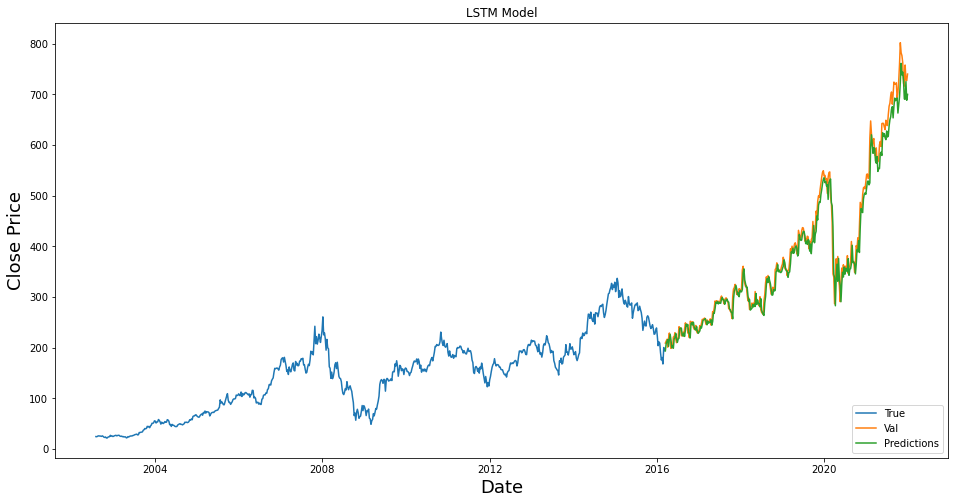

In [20]:
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['True', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [73]:
model.save('k_model.h5')

#### Prophet:

In [21]:
icicip = icici.reset_index()

In [22]:
df = icicip.filter(['Date', 'Close'])
df

,Date,Close
0,2002-08-04,24.663635
1,2002-08-11,24.400000
2,2002-08-18,25.336363
3,2002-08-25,26.109091
4,2002-09-01,25.981817
...,...,...
1008,2021-11-28,716.299988
1009,2021-12-05,758.000000
1010,2021-12-12,728.299988
1011,2021-12-19,727.099976


In [23]:
df.index[df['Close']<0]

Int64Index([], dtype='int64')

In [24]:
df['Close_shift'] = df['Close'] - df['Close'].shift(1)
y = df['Close_shift']

In [25]:
model1 = Prophet()

In [26]:
df.columns

Index(['Date', 'Close', 'Close_shift'], dtype='object')

In [27]:
df_prpht = df.rename(columns={'Date':'ds','Close_shift':'y'})

In [28]:
df_prpht.head()

,ds,Close,y
0,2002-08-04,24.663635,NaN
1,2002-08-11,24.400000,-0.263636
2,2002-08-18,25.336363,0.936363
3,2002-08-25,26.109091,0.772728
4,2002-09-01,25.981817,-0.127274


In [29]:
train_len1 = int(0.7*len(df))
train_len1

709

In [30]:
df_train = df_prpht[:train_len1]
df_test = df_prpht[train_len1:]
df_train, df_train.shape

(            ds       Close          y
 0   2002-08-04   24.663635        NaN
 1   2002-08-11   24.400000  -0.263636
 2   2002-08-18   25.336363   0.936363
 3   2002-08-25   26.109091   0.772728
 4   2002-09-01   25.981817  -0.127274
 ..         ...         ...        ...
 704 2016-01-31  190.363632 -18.863632
 705 2016-02-07  175.954544 -14.409088
 706 2016-02-14  180.727264   4.772720
 707 2016-02-21  168.000000 -12.727264
 708 2016-02-28  200.454544  32.454544
 
 [709 rows x 3 columns],
 (709, 3))

In [31]:
model1.fit(df_train)

08:15:11 - cmdstanpy - INFO - Chain [1] start processing
08:15:15 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
periods = len(df)-len(df_train)
periods

304

In [33]:
future_dates = model1.make_future_dataframe(periods=periods)

In [34]:
future_dates.shape

(1013, 1)

In [35]:
future_dates.head()

,ds
0,2002-08-04
1,2002-08-11
2,2002-08-18
3,2002-08-25
4,2002-09-01


In [36]:
prediction = model1.predict(future_dates)

In [37]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-08-04,0.413156,-11.101974,9.805493,0.413156,0.413156,-0.497240,-0.497240,-0.497240,-0.497240,-0.497240,-0.497240,0.0,0.0,0.0,-0.084084
1,2002-08-11,0.412739,-11.324669,9.129845,0.412739,0.412739,-1.837364,-1.837364,-1.837364,-1.837364,-1.837364,-1.837364,0.0,0.0,0.0,-1.424625
2,2002-08-18,0.412323,-12.921206,8.579530,0.412323,0.412323,-1.982249,-1.982249,-1.982249,-1.982249,-1.982249,-1.982249,0.0,0.0,0.0,-1.569926
3,2002-08-25,0.411907,-10.020452,11.187004,0.411907,0.411907,-0.081450,-0.081450,-0.081450,-0.081450,-0.081450,-0.081450,0.0,0.0,0.0,0.330457
4,2002-09-01,0.411491,-8.246586,14.044310,0.411491,0.411491,2.619788,2.619788,2.619788,2.619788,2.619788,2.619788,0.0,0.0,0.0,3.031279


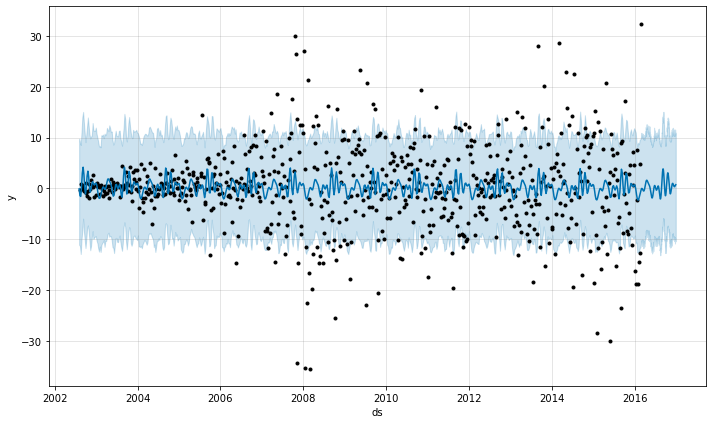

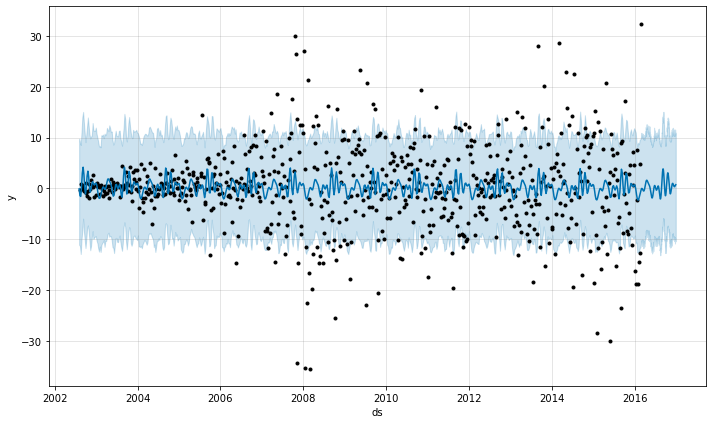

In [38]:
model1.plot(prediction)

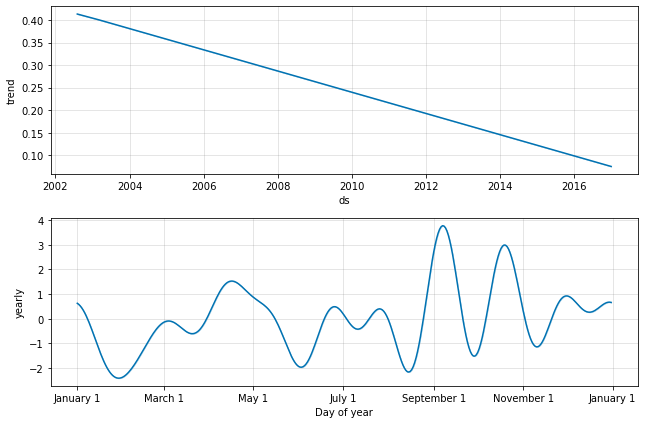

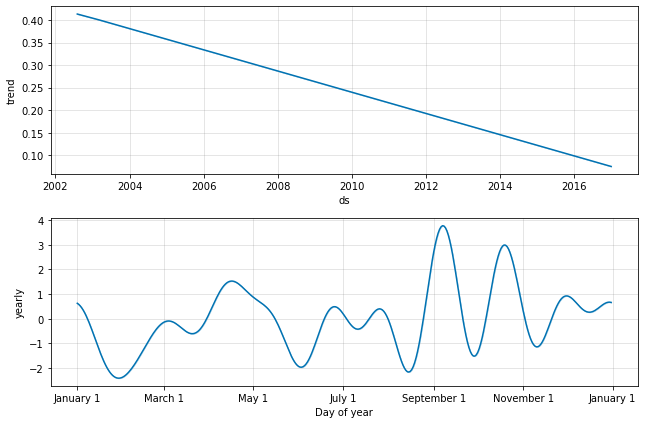

In [39]:
model1.plot_components(prediction)

In [40]:
df_train.shape, len(df)-len(df_train)

((709, 3), 304)

In [41]:
cv = cross_validation(model1, initial='709 days', period='3 days', horizon='304 days')

  0%|          | 0/1313 [00:00<?, ?it/s]

08:15:24 - cmdstanpy - INFO - Chain [1] start processing
08:15:24 - cmdstanpy - INFO - Chain [1] done processing
08:15:25 - cmdstanpy - INFO - Chain [1] start processing
08:15:25 - cmdstanpy - INFO - Chain [1] done processing
08:15:25 - cmdstanpy - INFO - Chain [1] start processing
08:15:25 - cmdstanpy - INFO - Chain [1] done processing
08:15:26 - cmdstanpy - INFO - Chain [1] start processing
08:15:26 - cmdstanpy - INFO - Chain [1] done processing
08:15:27 - cmdstanpy - INFO - Chain [1] start processing
08:15:27 - cmdstanpy - INFO - Chain [1] done processing
08:15:27 - cmdstanpy - INFO - Chain [1] start processing
08:15:27 - cmdstanpy - INFO - Chain [1] done processing
08:15:28 - cmdstanpy - INFO - Chain [1] start processing
08:15:28 - cmdstanpy - INFO - Chain [1] done processing
08:15:29 - cmdstanpy - INFO - Chain [1] start processing
08:15:29 - cmdstanpy - INFO - Chain [1] done processing
08:15:29 - cmdstanpy - INFO - Chain [1] start processing
08:15:29 - cmdstanpy - INFO - Chain [1]

08:16:11 - cmdstanpy - INFO - Chain [1] done processing
08:16:11 - cmdstanpy - INFO - Chain [1] start processing
08:16:12 - cmdstanpy - INFO - Chain [1] done processing
08:16:12 - cmdstanpy - INFO - Chain [1] start processing
08:16:12 - cmdstanpy - INFO - Chain [1] done processing
08:16:13 - cmdstanpy - INFO - Chain [1] start processing
08:16:13 - cmdstanpy - INFO - Chain [1] done processing
08:16:13 - cmdstanpy - INFO - Chain [1] start processing
08:16:13 - cmdstanpy - INFO - Chain [1] done processing
08:16:14 - cmdstanpy - INFO - Chain [1] start processing
08:16:14 - cmdstanpy - INFO - Chain [1] done processing
08:16:15 - cmdstanpy - INFO - Chain [1] start processing
08:16:15 - cmdstanpy - INFO - Chain [1] done processing
08:16:15 - cmdstanpy - INFO - Chain [1] start processing
08:16:15 - cmdstanpy - INFO - Chain [1] done processing
08:16:16 - cmdstanpy - INFO - Chain [1] start processing
08:16:16 - cmdstanpy - INFO - Chain [1] done processing
08:16:17 - cmdstanpy - INFO - Chain [1] 

08:16:59 - cmdstanpy - INFO - Chain [1] done processing
08:16:59 - cmdstanpy - INFO - Chain [1] start processing
08:16:59 - cmdstanpy - INFO - Chain [1] done processing
08:17:00 - cmdstanpy - INFO - Chain [1] start processing
08:17:00 - cmdstanpy - INFO - Chain [1] done processing
08:17:00 - cmdstanpy - INFO - Chain [1] start processing
08:17:01 - cmdstanpy - INFO - Chain [1] done processing
08:17:01 - cmdstanpy - INFO - Chain [1] start processing
08:17:01 - cmdstanpy - INFO - Chain [1] done processing
08:17:02 - cmdstanpy - INFO - Chain [1] start processing
08:17:02 - cmdstanpy - INFO - Chain [1] done processing
08:17:02 - cmdstanpy - INFO - Chain [1] start processing
08:17:02 - cmdstanpy - INFO - Chain [1] done processing
08:17:03 - cmdstanpy - INFO - Chain [1] start processing
08:17:03 - cmdstanpy - INFO - Chain [1] done processing
08:17:04 - cmdstanpy - INFO - Chain [1] start processing
08:17:04 - cmdstanpy - INFO - Chain [1] done processing
08:17:04 - cmdstanpy - INFO - Chain [1] 

08:17:47 - cmdstanpy - INFO - Chain [1] done processing
08:17:48 - cmdstanpy - INFO - Chain [1] start processing
08:17:48 - cmdstanpy - INFO - Chain [1] done processing
08:17:49 - cmdstanpy - INFO - Chain [1] start processing
08:17:49 - cmdstanpy - INFO - Chain [1] done processing
08:17:49 - cmdstanpy - INFO - Chain [1] start processing
08:17:49 - cmdstanpy - INFO - Chain [1] done processing
08:17:50 - cmdstanpy - INFO - Chain [1] start processing
08:17:50 - cmdstanpy - INFO - Chain [1] done processing
08:17:51 - cmdstanpy - INFO - Chain [1] start processing
08:17:51 - cmdstanpy - INFO - Chain [1] done processing
08:17:52 - cmdstanpy - INFO - Chain [1] start processing
08:17:52 - cmdstanpy - INFO - Chain [1] done processing
08:17:52 - cmdstanpy - INFO - Chain [1] start processing
08:17:52 - cmdstanpy - INFO - Chain [1] done processing
08:17:53 - cmdstanpy - INFO - Chain [1] start processing
08:17:53 - cmdstanpy - INFO - Chain [1] done processing
08:17:54 - cmdstanpy - INFO - Chain [1] 

08:18:38 - cmdstanpy - INFO - Chain [1] done processing
08:18:38 - cmdstanpy - INFO - Chain [1] start processing
08:18:38 - cmdstanpy - INFO - Chain [1] done processing
08:18:39 - cmdstanpy - INFO - Chain [1] start processing
08:18:39 - cmdstanpy - INFO - Chain [1] done processing
08:18:40 - cmdstanpy - INFO - Chain [1] start processing
08:18:40 - cmdstanpy - INFO - Chain [1] done processing
08:18:40 - cmdstanpy - INFO - Chain [1] start processing
08:18:40 - cmdstanpy - INFO - Chain [1] done processing
08:18:41 - cmdstanpy - INFO - Chain [1] start processing
08:18:41 - cmdstanpy - INFO - Chain [1] done processing
08:18:42 - cmdstanpy - INFO - Chain [1] start processing
08:18:42 - cmdstanpy - INFO - Chain [1] done processing
08:18:42 - cmdstanpy - INFO - Chain [1] start processing
08:18:42 - cmdstanpy - INFO - Chain [1] done processing
08:18:43 - cmdstanpy - INFO - Chain [1] start processing
08:18:43 - cmdstanpy - INFO - Chain [1] done processing
08:18:44 - cmdstanpy - INFO - Chain [1] 

08:19:27 - cmdstanpy - INFO - Chain [1] done processing
08:19:28 - cmdstanpy - INFO - Chain [1] start processing
08:19:28 - cmdstanpy - INFO - Chain [1] done processing
08:19:29 - cmdstanpy - INFO - Chain [1] start processing
08:19:29 - cmdstanpy - INFO - Chain [1] done processing
08:19:29 - cmdstanpy - INFO - Chain [1] start processing
08:19:29 - cmdstanpy - INFO - Chain [1] done processing
08:19:30 - cmdstanpy - INFO - Chain [1] start processing
08:19:30 - cmdstanpy - INFO - Chain [1] done processing
08:19:31 - cmdstanpy - INFO - Chain [1] start processing
08:19:31 - cmdstanpy - INFO - Chain [1] done processing
08:19:31 - cmdstanpy - INFO - Chain [1] start processing
08:19:31 - cmdstanpy - INFO - Chain [1] done processing
08:19:32 - cmdstanpy - INFO - Chain [1] start processing
08:19:32 - cmdstanpy - INFO - Chain [1] done processing
08:19:33 - cmdstanpy - INFO - Chain [1] start processing
08:19:33 - cmdstanpy - INFO - Chain [1] done processing
08:19:33 - cmdstanpy - INFO - Chain [1] 

08:20:17 - cmdstanpy - INFO - Chain [1] done processing
08:20:18 - cmdstanpy - INFO - Chain [1] start processing
08:20:18 - cmdstanpy - INFO - Chain [1] done processing
08:20:18 - cmdstanpy - INFO - Chain [1] start processing
08:20:18 - cmdstanpy - INFO - Chain [1] done processing
08:20:19 - cmdstanpy - INFO - Chain [1] start processing
08:20:19 - cmdstanpy - INFO - Chain [1] done processing
08:20:20 - cmdstanpy - INFO - Chain [1] start processing
08:20:20 - cmdstanpy - INFO - Chain [1] done processing
08:20:20 - cmdstanpy - INFO - Chain [1] start processing
08:20:20 - cmdstanpy - INFO - Chain [1] done processing
08:20:21 - cmdstanpy - INFO - Chain [1] start processing
08:20:21 - cmdstanpy - INFO - Chain [1] done processing
08:20:22 - cmdstanpy - INFO - Chain [1] start processing
08:20:22 - cmdstanpy - INFO - Chain [1] done processing
08:20:22 - cmdstanpy - INFO - Chain [1] start processing
08:20:22 - cmdstanpy - INFO - Chain [1] done processing
08:20:23 - cmdstanpy - INFO - Chain [1] 

08:21:07 - cmdstanpy - INFO - Chain [1] done processing
08:21:08 - cmdstanpy - INFO - Chain [1] start processing
08:21:08 - cmdstanpy - INFO - Chain [1] done processing
08:21:09 - cmdstanpy - INFO - Chain [1] start processing
08:21:09 - cmdstanpy - INFO - Chain [1] done processing
08:21:10 - cmdstanpy - INFO - Chain [1] start processing
08:21:10 - cmdstanpy - INFO - Chain [1] done processing
08:21:10 - cmdstanpy - INFO - Chain [1] start processing
08:21:10 - cmdstanpy - INFO - Chain [1] done processing
08:21:11 - cmdstanpy - INFO - Chain [1] start processing
08:21:11 - cmdstanpy - INFO - Chain [1] done processing
08:21:12 - cmdstanpy - INFO - Chain [1] start processing
08:21:12 - cmdstanpy - INFO - Chain [1] done processing
08:21:12 - cmdstanpy - INFO - Chain [1] start processing
08:21:12 - cmdstanpy - INFO - Chain [1] done processing
08:21:13 - cmdstanpy - INFO - Chain [1] start processing
08:21:13 - cmdstanpy - INFO - Chain [1] done processing
08:21:14 - cmdstanpy - INFO - Chain [1] 

08:22:00 - cmdstanpy - INFO - Chain [1] done processing
08:22:01 - cmdstanpy - INFO - Chain [1] start processing
08:22:01 - cmdstanpy - INFO - Chain [1] done processing
08:22:01 - cmdstanpy - INFO - Chain [1] start processing
08:22:01 - cmdstanpy - INFO - Chain [1] done processing
08:22:02 - cmdstanpy - INFO - Chain [1] start processing
08:22:02 - cmdstanpy - INFO - Chain [1] done processing
08:22:03 - cmdstanpy - INFO - Chain [1] start processing
08:22:03 - cmdstanpy - INFO - Chain [1] done processing
08:22:03 - cmdstanpy - INFO - Chain [1] start processing
08:22:03 - cmdstanpy - INFO - Chain [1] done processing
08:22:04 - cmdstanpy - INFO - Chain [1] start processing
08:22:04 - cmdstanpy - INFO - Chain [1] done processing
08:22:05 - cmdstanpy - INFO - Chain [1] start processing
08:22:05 - cmdstanpy - INFO - Chain [1] done processing
08:22:05 - cmdstanpy - INFO - Chain [1] start processing
08:22:05 - cmdstanpy - INFO - Chain [1] done processing
08:22:06 - cmdstanpy - INFO - Chain [1] 

08:22:55 - cmdstanpy - INFO - Chain [1] done processing
08:22:56 - cmdstanpy - INFO - Chain [1] start processing
08:22:56 - cmdstanpy - INFO - Chain [1] done processing
08:22:56 - cmdstanpy - INFO - Chain [1] start processing
08:22:56 - cmdstanpy - INFO - Chain [1] done processing
08:22:57 - cmdstanpy - INFO - Chain [1] start processing
08:22:57 - cmdstanpy - INFO - Chain [1] done processing
08:22:58 - cmdstanpy - INFO - Chain [1] start processing
08:22:58 - cmdstanpy - INFO - Chain [1] done processing
08:22:58 - cmdstanpy - INFO - Chain [1] start processing
08:22:59 - cmdstanpy - INFO - Chain [1] done processing
08:22:59 - cmdstanpy - INFO - Chain [1] start processing
08:22:59 - cmdstanpy - INFO - Chain [1] done processing
08:23:00 - cmdstanpy - INFO - Chain [1] start processing
08:23:00 - cmdstanpy - INFO - Chain [1] done processing
08:23:01 - cmdstanpy - INFO - Chain [1] start processing
08:23:01 - cmdstanpy - INFO - Chain [1] done processing
08:23:02 - cmdstanpy - INFO - Chain [1] 

08:23:46 - cmdstanpy - INFO - Chain [1] done processing
08:23:47 - cmdstanpy - INFO - Chain [1] start processing
08:23:47 - cmdstanpy - INFO - Chain [1] done processing
08:23:47 - cmdstanpy - INFO - Chain [1] start processing
08:23:47 - cmdstanpy - INFO - Chain [1] done processing
08:23:48 - cmdstanpy - INFO - Chain [1] start processing
08:23:48 - cmdstanpy - INFO - Chain [1] done processing
08:23:49 - cmdstanpy - INFO - Chain [1] start processing
08:23:49 - cmdstanpy - INFO - Chain [1] done processing
08:23:49 - cmdstanpy - INFO - Chain [1] start processing
08:23:49 - cmdstanpy - INFO - Chain [1] done processing
08:23:50 - cmdstanpy - INFO - Chain [1] start processing
08:23:50 - cmdstanpy - INFO - Chain [1] done processing
08:23:51 - cmdstanpy - INFO - Chain [1] start processing
08:23:51 - cmdstanpy - INFO - Chain [1] done processing
08:23:51 - cmdstanpy - INFO - Chain [1] start processing
08:23:51 - cmdstanpy - INFO - Chain [1] done processing
08:23:52 - cmdstanpy - INFO - Chain [1] 

08:24:35 - cmdstanpy - INFO - Chain [1] done processing
08:24:36 - cmdstanpy - INFO - Chain [1] start processing
08:24:36 - cmdstanpy - INFO - Chain [1] done processing
08:24:37 - cmdstanpy - INFO - Chain [1] start processing
08:24:37 - cmdstanpy - INFO - Chain [1] done processing
08:24:37 - cmdstanpy - INFO - Chain [1] start processing
08:24:37 - cmdstanpy - INFO - Chain [1] done processing
08:24:38 - cmdstanpy - INFO - Chain [1] start processing
08:24:38 - cmdstanpy - INFO - Chain [1] done processing
08:24:39 - cmdstanpy - INFO - Chain [1] start processing
08:24:39 - cmdstanpy - INFO - Chain [1] done processing
08:24:39 - cmdstanpy - INFO - Chain [1] start processing
08:24:39 - cmdstanpy - INFO - Chain [1] done processing
08:24:40 - cmdstanpy - INFO - Chain [1] start processing
08:24:40 - cmdstanpy - INFO - Chain [1] done processing
08:24:41 - cmdstanpy - INFO - Chain [1] start processing
08:24:41 - cmdstanpy - INFO - Chain [1] done processing
08:24:41 - cmdstanpy - INFO - Chain [1] 

08:25:25 - cmdstanpy - INFO - Chain [1] done processing
08:25:26 - cmdstanpy - INFO - Chain [1] start processing
08:25:26 - cmdstanpy - INFO - Chain [1] done processing
08:25:27 - cmdstanpy - INFO - Chain [1] start processing
08:25:27 - cmdstanpy - INFO - Chain [1] done processing
08:25:27 - cmdstanpy - INFO - Chain [1] start processing
08:25:27 - cmdstanpy - INFO - Chain [1] done processing
08:25:28 - cmdstanpy - INFO - Chain [1] start processing
08:25:28 - cmdstanpy - INFO - Chain [1] done processing
08:25:29 - cmdstanpy - INFO - Chain [1] start processing
08:25:29 - cmdstanpy - INFO - Chain [1] done processing
08:25:29 - cmdstanpy - INFO - Chain [1] start processing
08:25:29 - cmdstanpy - INFO - Chain [1] done processing
08:25:30 - cmdstanpy - INFO - Chain [1] start processing
08:25:30 - cmdstanpy - INFO - Chain [1] done processing
08:25:31 - cmdstanpy - INFO - Chain [1] start processing
08:25:31 - cmdstanpy - INFO - Chain [1] done processing
08:25:31 - cmdstanpy - INFO - Chain [1] 

08:26:16 - cmdstanpy - INFO - Chain [1] done processing
08:26:16 - cmdstanpy - INFO - Chain [1] start processing
08:26:17 - cmdstanpy - INFO - Chain [1] done processing
08:26:17 - cmdstanpy - INFO - Chain [1] start processing
08:26:17 - cmdstanpy - INFO - Chain [1] done processing
08:26:18 - cmdstanpy - INFO - Chain [1] start processing
08:26:18 - cmdstanpy - INFO - Chain [1] done processing
08:26:19 - cmdstanpy - INFO - Chain [1] start processing
08:26:19 - cmdstanpy - INFO - Chain [1] done processing
08:26:19 - cmdstanpy - INFO - Chain [1] start processing
08:26:19 - cmdstanpy - INFO - Chain [1] done processing
08:26:20 - cmdstanpy - INFO - Chain [1] start processing
08:26:20 - cmdstanpy - INFO - Chain [1] done processing
08:26:21 - cmdstanpy - INFO - Chain [1] start processing
08:26:21 - cmdstanpy - INFO - Chain [1] done processing
08:26:21 - cmdstanpy - INFO - Chain [1] start processing
08:26:21 - cmdstanpy - INFO - Chain [1] done processing
08:26:22 - cmdstanpy - INFO - Chain [1] 

08:27:06 - cmdstanpy - INFO - Chain [1] done processing
08:27:08 - cmdstanpy - INFO - Chain [1] start processing
08:27:08 - cmdstanpy - INFO - Chain [1] done processing
08:27:11 - cmdstanpy - INFO - Chain [1] start processing
08:27:11 - cmdstanpy - INFO - Chain [1] done processing
08:27:13 - cmdstanpy - INFO - Chain [1] start processing
08:27:13 - cmdstanpy - INFO - Chain [1] done processing
08:27:15 - cmdstanpy - INFO - Chain [1] start processing
08:27:15 - cmdstanpy - INFO - Chain [1] done processing
08:27:17 - cmdstanpy - INFO - Chain [1] start processing
08:27:17 - cmdstanpy - INFO - Chain [1] done processing
08:27:19 - cmdstanpy - INFO - Chain [1] start processing
08:27:19 - cmdstanpy - INFO - Chain [1] done processing
08:27:21 - cmdstanpy - INFO - Chain [1] start processing
08:27:21 - cmdstanpy - INFO - Chain [1] done processing
08:27:23 - cmdstanpy - INFO - Chain [1] start processing
08:27:23 - cmdstanpy - INFO - Chain [1] done processing
08:27:24 - cmdstanpy - INFO - Chain [1] 

08:28:25 - cmdstanpy - INFO - Chain [1] done processing
08:28:25 - cmdstanpy - INFO - Chain [1] start processing
08:28:25 - cmdstanpy - INFO - Chain [1] done processing
08:28:26 - cmdstanpy - INFO - Chain [1] start processing
08:28:26 - cmdstanpy - INFO - Chain [1] done processing
08:28:27 - cmdstanpy - INFO - Chain [1] start processing
08:28:27 - cmdstanpy - INFO - Chain [1] done processing
08:28:28 - cmdstanpy - INFO - Chain [1] start processing
08:28:28 - cmdstanpy - INFO - Chain [1] done processing
08:28:29 - cmdstanpy - INFO - Chain [1] start processing
08:28:29 - cmdstanpy - INFO - Chain [1] done processing
08:28:29 - cmdstanpy - INFO - Chain [1] start processing
08:28:30 - cmdstanpy - INFO - Chain [1] done processing
08:28:30 - cmdstanpy - INFO - Chain [1] start processing
08:28:30 - cmdstanpy - INFO - Chain [1] done processing
08:28:31 - cmdstanpy - INFO - Chain [1] start processing
08:28:31 - cmdstanpy - INFO - Chain [1] done processing
08:28:32 - cmdstanpy - INFO - Chain [1] 

08:29:20 - cmdstanpy - INFO - Chain [1] done processing
08:29:21 - cmdstanpy - INFO - Chain [1] start processing
08:29:21 - cmdstanpy - INFO - Chain [1] done processing
08:29:21 - cmdstanpy - INFO - Chain [1] start processing
08:29:21 - cmdstanpy - INFO - Chain [1] done processing
08:29:22 - cmdstanpy - INFO - Chain [1] start processing
08:29:22 - cmdstanpy - INFO - Chain [1] done processing
08:29:23 - cmdstanpy - INFO - Chain [1] start processing
08:29:23 - cmdstanpy - INFO - Chain [1] done processing
08:29:23 - cmdstanpy - INFO - Chain [1] start processing
08:29:24 - cmdstanpy - INFO - Chain [1] done processing
08:29:24 - cmdstanpy - INFO - Chain [1] start processing
08:29:24 - cmdstanpy - INFO - Chain [1] done processing
08:29:25 - cmdstanpy - INFO - Chain [1] start processing
08:29:25 - cmdstanpy - INFO - Chain [1] done processing
08:29:26 - cmdstanpy - INFO - Chain [1] start processing
08:29:26 - cmdstanpy - INFO - Chain [1] done processing
08:29:26 - cmdstanpy - INFO - Chain [1] 

08:30:12 - cmdstanpy - INFO - Chain [1] done processing
08:30:13 - cmdstanpy - INFO - Chain [1] start processing
08:30:13 - cmdstanpy - INFO - Chain [1] done processing
08:30:13 - cmdstanpy - INFO - Chain [1] start processing
08:30:14 - cmdstanpy - INFO - Chain [1] done processing
08:30:14 - cmdstanpy - INFO - Chain [1] start processing
08:30:14 - cmdstanpy - INFO - Chain [1] done processing
08:30:15 - cmdstanpy - INFO - Chain [1] start processing
08:30:15 - cmdstanpy - INFO - Chain [1] done processing
08:30:16 - cmdstanpy - INFO - Chain [1] start processing
08:30:16 - cmdstanpy - INFO - Chain [1] done processing
08:30:16 - cmdstanpy - INFO - Chain [1] start processing
08:30:16 - cmdstanpy - INFO - Chain [1] done processing
08:30:17 - cmdstanpy - INFO - Chain [1] start processing
08:30:17 - cmdstanpy - INFO - Chain [1] done processing
08:30:18 - cmdstanpy - INFO - Chain [1] start processing
08:30:18 - cmdstanpy - INFO - Chain [1] done processing
08:30:18 - cmdstanpy - INFO - Chain [1] 

In [42]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2004-07-25,0.180631,-2.040193,2.628043,1.118183,2004-07-20
1,2004-08-01,0.378884,-1.898136,2.897136,0.918182,2004-07-20
2,2004-08-08,1.173021,-1.111683,3.393639,0.472725,2004-07-20
3,2004-08-15,1.748456,-0.527694,4.131234,-1.327271,2004-07-20
4,2004-08-22,1.596484,-0.786481,3.922178,0.163635,2004-07-20


In [43]:
cv.shape

(57022, 6)

In [44]:
df_train_pm = performance_metrics(cv)
df_train_pm

,horizon,mse,rmse,mae,mdape,smape,coverage
0,31 days,77.838288,8.822601,6.493570,1.014337,1.602496,0.656343
1,32 days,78.111371,8.838064,6.505517,1.014100,1.602524,0.656028
2,33 days,77.880353,8.824985,6.496896,1.014245,1.603077,0.656378
3,34 days,77.913574,8.826867,6.497897,1.013498,1.602598,0.655257
4,35 days,78.186656,8.842322,6.509845,1.013318,1.602626,0.654836
...,...,...,...,...,...,...,...
269,300 days,85.722827,9.258662,6.928836,1.008921,1.601727,0.620113
270,301 days,85.759932,9.260666,6.932193,1.009325,1.601490,0.619866
271,302 days,86.009375,9.274124,6.941624,1.008500,1.601719,0.620249
272,303 days,85.800077,9.262833,6.933412,1.009325,1.601814,0.621033


In [45]:
MSE = sum(df_train_pm['mse'])/len(df_train_pm)
RMSE = sum(df_train_pm['rmse'])/len(df_train_pm)
MSE, RMSE

(82.07290679846717, 9.058622094087125)

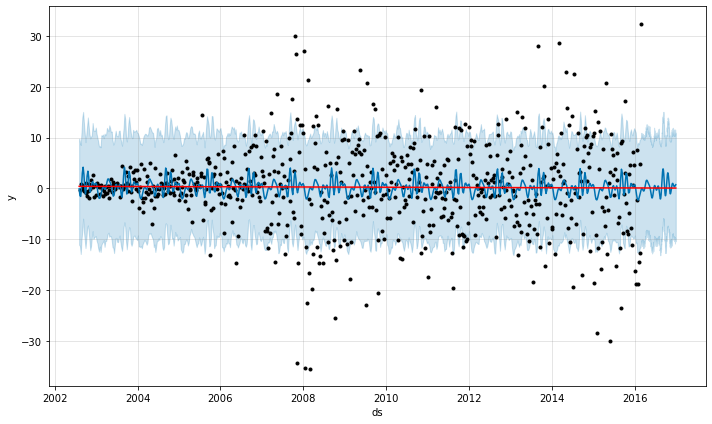

In [46]:
fig = model1.plot(prediction)
a = add_changepoints_to_plot(fig.gca(), model1, prediction)

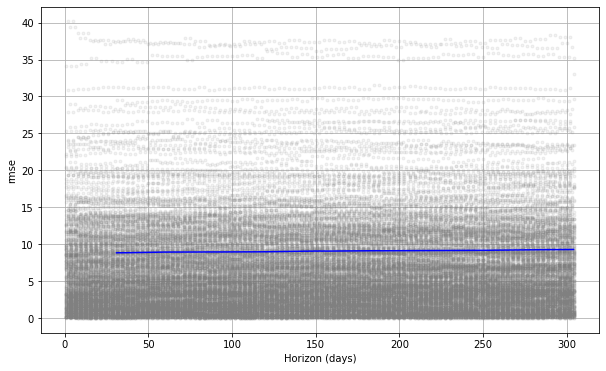

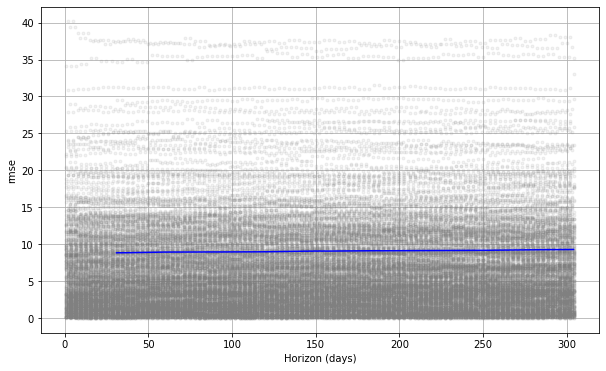

In [47]:
plot_cross_validation_metric(cv, metric='rmse')

#### ARIMA

In [48]:
model2 = pm.auto_arima(df_train['Close'], start_p=1, start_q=1, test='adf',
                      max_p=3, max_q=3, m=1, d=None, seasonal=False, start_P=0,
                      D=0, trace=True, error_action='ignore', suppress_warnings=True,
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5006.870, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5010.554, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5004.888, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5005.067, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5009.186, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5006.869, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5008.504, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5003.642, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5005.614, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5005.617, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5003.831, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5007.181, Time=0.31 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.417 seconds


In [49]:
model2 = ARIMA(df_train['Close'], order=(0,1,1))
model2_fit = model2.fit()

In [50]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  709
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2499.916
Date:                Fri, 04 Nov 2022   AIC                           5003.831
Time:                        08:31:24   BIC                           5012.956
Sample:                             0   HQIC                          5007.357
                                - 709                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1012      0.026     -3.877      0.000      -0.152      -0.050
sigma2        68.3069      2.461     27.759      0.000      63.484      73.130
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               174.54
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               7.06   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
data = icici.sort_index(ascending=True, axis=0)

In [52]:
train = data[:709]
valid = data[709:]

In [53]:
training = train['Close']
validation = train['Close']

In [54]:
model_ar = auto_arima(training, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                     start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                     suppress_warnings=True)
model_ar.fit(training)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.91 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5463.369, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5197.799, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5453.711, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5110.569, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5117.463, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5112.547, Time=0.89 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5112.552, Time=1.00 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5110.820, Time=0.71 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5113.862, Time=2.39 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=5112.494, Time=3.08 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [55]:
forecast = model_ar.predict(n_periods=304)
forecast = pd.DataFrame(forecast, index=valid.index, columns=['Prediction'])

In [56]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

651.7687660805348

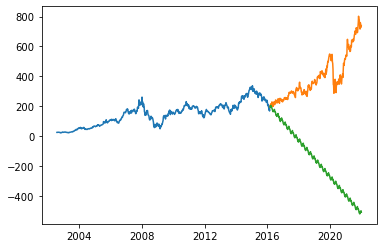

In [57]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

#### Moving Average

In [58]:
data = icicip.sort_index(ascending=True, axis=0)

In [59]:
new_data = pd.DataFrame(index=range(0, len(icicip)), columns=['Date', 'Close'])

In [60]:
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
train = new_data[:709]
valid = new_data[709:]

In [61]:
train.shape, valid.shape

((709, 2), (304, 2))

In [62]:
preds = []
for i in range(0, valid.shape[0]):
    a = train['Close'][len(train)-190+i:].sum() + sum(preds)
    b = a/190
    preds.append(b)

rmse = np.sqrt(np.mean(np.array(np.power((valid['Close'])-preds,2))))
rmse

151.60710735545533

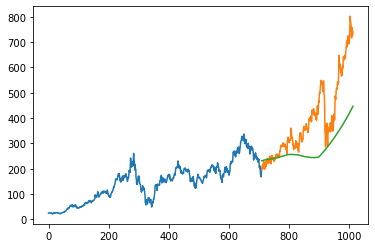

In [63]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

#### KNN Model

In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [65]:
new_data = pd.DataFrame(icici, columns=['Open', 'High', 'Low', 'Close'])
train = new_data[:709]
valid = new_data[709:]

In [66]:
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

In [67]:
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

In [68]:
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model_knn = GridSearchCV(knn, params, cv = 5)

In [69]:
model_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]})

In [70]:
pred = model_knn.predict(x_valid)

In [71]:
rmse_knn = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(pred)),2)))
rmse_knn

281.0384600677503

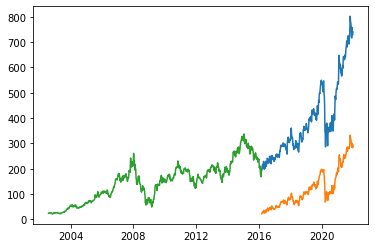

In [72]:
valid['Predictions'] = 0
valid['Predictions'] = pred
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])